In [1]:
# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os

# Deep Learning
import tensorflow as tf

2023-04-24 15:40:17.395993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 15:40:18.690946: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 15:40:18.946108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-24 15:40:18.946146: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [2]:
from typing import Dict, List, Tuple, Sequence

In [3]:
#load the data set
url = "https://wagon-public-datasets.s3.amazonaws.com/deep_learning_datasets/weather_every_three_hours_engineered.csv"
df = pd.read_csv(url).drop(columns = ['Unnamed: 0'])
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day_sin,Day_cos,Year_sin,Year_cos
0,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,7.071068e-01,7.071068e-01,0.011483,0.999934
1,997.71,-9.67,263.66,-10.62,92.70,2.93,2.71,0.21,1.69,2.72,1317.71,-0.041452,0.027960,-0.414519,0.279596,1.000000e+00,4.339955e-12,0.013633,0.999907
2,999.69,-7.66,265.52,-8.84,91.20,3.43,3.13,0.30,1.95,3.13,1310.14,-0.314796,-0.128466,-0.583298,-0.238040,7.071068e-01,-7.071068e-01,0.015783,0.999875
3,1000.30,-6.87,266.27,-8.28,89.60,3.64,3.27,0.38,2.03,3.26,1306.98,-1.834577,-0.141163,-2.622249,-0.201771,6.903299e-12,-1.000000e+00,0.017933,0.999839
4,999.88,-5.69,267.48,-7.00,90.40,3.99,3.61,0.38,2.25,3.61,1300.51,-0.825870,0.828758,-1.327039,1.331679,-7.071068e-01,-7.071068e-01,0.020083,0.999798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23358,1006.23,-6.31,266.37,-8.42,84.90,3.81,3.23,0.57,2.00,3.21,1312.01,-1.279930,-0.013404,-1.839899,-0.019268,6.755902e-01,-7.372773e-01,-0.000268,1.000000
23359,1004.62,-0.71,272.09,-5.97,67.37,5.80,3.91,1.89,2.42,3.89,1282.65,-0.976457,-0.412471,-1.916066,-0.809378,-4.361939e-02,-9.990482e-01,0.001883,0.999998
23360,1003.09,4.97,277.88,-3.04,56.03,8.71,4.88,3.83,3.03,4.86,1254.09,-0.403185,-0.359224,-0.776504,-0.691840,-7.372773e-01,-6.755902e-01,0.004033,0.999992
23361,1002.27,-0.42,272.56,-4.92,71.50,5.92,4.23,1.69,2.63,4.22,1278.14,-0.266024,-0.350473,-0.604599,-0.796530,-9.990482e-01,4.361939e-02,0.006183,0.999981


In [4]:
#define the global variables of our dataset
TARGET = 'T (degC)'
N_TARGETS = 1
N_FEATURES = 19

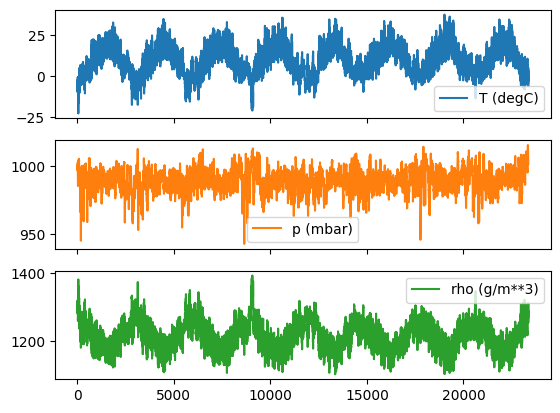

In [5]:
plot_cols = [TARGET, 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

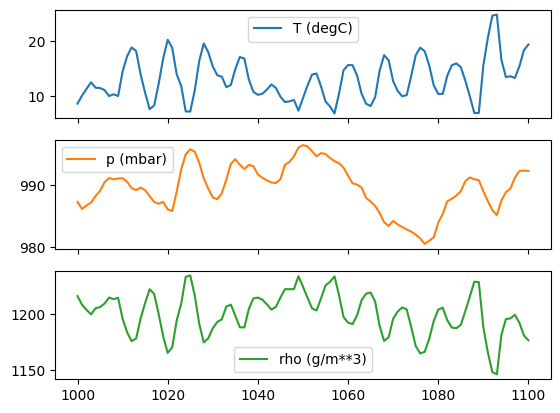

In [6]:
zoomed_slice = slice(1000,1100)

plot_features = df.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

In [7]:
FOLD_LENGTH = 8*365 * 3 # every 3 hrs x 8 = 24h
                        # three years
    
FOLD_STRIDE = 8*91 # every 3 hrs x 8 = 24h
                   # 1 quarter = 91 days

TRAIN_TEST_RATIO = 0.66

In [8]:
#function slides through Time series df to create folds of equal length
#returns a list of folds, each as a df
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    folds = []
    size = len(df)
    for index in range (0, size, fold_stride):
        if (index + fold_length) > size:
            break
        fold = df.iloc[index: index + fold_length, :]
        folds.append(fold)
    return folds

folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

In [9]:
fold = folds[0]
fold

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day_sin,Day_cos,Year_sin,Year_cos
0,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,7.071068e-01,7.071068e-01,0.011483,0.999934
1,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,-0.041452,0.027960,-0.414519,0.279596,1.000000e+00,4.339955e-12,0.013633,0.999907
2,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,-0.314796,-0.128466,-0.583298,-0.238040,7.071068e-01,-7.071068e-01,0.015783,0.999875
3,1000.30,-6.87,266.27,-8.28,89.6,3.64,3.27,0.38,2.03,3.26,1306.98,-1.834577,-0.141163,-2.622249,-0.201771,6.903299e-12,-1.000000e+00,0.017933,0.999839
4,999.88,-5.69,267.48,-7.00,90.4,3.99,3.61,0.38,2.25,3.61,1300.51,-0.825870,0.828758,-1.327039,1.331679,-7.071068e-01,-7.071068e-01,0.020083,0.999798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,980.34,1.45,276.18,0.03,90.2,6.79,6.12,0.67,3.89,6.24,1240.67,-0.604351,-3.731375,-1.191115,-7.354165,-8.715574e-02,-9.961947e-01,-0.028744,0.999587
8756,983.25,2.23,276.73,0.21,86.4,7.18,6.20,0.98,3.93,6.31,1240.81,-0.432628,-2.126437,-0.849307,-4.174479,-7.660444e-01,-6.427876e-01,-0.026594,0.999646
8757,985.46,1.69,276.00,-0.52,85.2,6.90,5.88,1.02,3.72,5.97,1246.23,-0.626578,-2.513066,-0.977364,-3.919995,-9.961947e-01,8.715574e-02,-0.024445,0.999701
8758,986.63,2.16,276.38,-1.14,78.7,7.14,5.62,1.52,3.55,5.70,1245.68,-0.773266,-3.669409,-1.222791,-5.802558,-6.427876e-01,7.660444e-01,-0.022295,0.999751


In [10]:
INPUT_LENGTH = 8 * 14 # records every 3 hours x 8 = 24 hours
                      # two weeks

In [11]:
#returns a train and test df
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    
    last_train = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train, :]
    first_test_idx = last_train - input_length
    fold_test = fold.iloc[first_test_idx:, :]
    
    return (fold_train, fold_test)

In [12]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [13]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH/8)} days = {int(INPUT_LENGTH/8/7)} weeks')

N_FEATURES = 19
INPUT_LENGTH = 112 timesteps = 14 days = 2 weeks


In [14]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Only predicting 1 value ahead
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


In [15]:
# a fold will return a sequence (X_i, y_i)
# with starting point of the sequence being chosen at random
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):

    x = 0
    y = len(fold) - (input_length + output_length) + 1
    
    random_start = np.random.randint(x, y)
    X_i = fold.iloc[random_start: random_start+input_length]    
    y_i = fold.iloc[random_start + input_length: random_start + input_length + output_length][[TARGET]]
    
    return (X_i, y_i)

In [16]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [17]:
# Should not allow some truncated (X_i,y_i) pairs to be generating,
X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

In [18]:
#given a fold, and other inputs, will return X and y
def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int
):
    X = []
    y = []
    
    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)

In [19]:
N_TRAIN = 6666 # number_of_sequences_train
N_TEST =  3333 # number_of_sequences_test

X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

In [20]:
SEQUENCE_STRIDE = 1

In [21]:
#slides through a fold time series to create sequences of equal X and y
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [22]:
print("FOLD_LENGTH") 
print(f"= {FOLD_LENGTH} timesteps")
print(f"= {int(FOLD_LENGTH/8)} days") # 8 records per day, every 3 hours
print(f"= {int(FOLD_LENGTH/8/7)} weeks")

FOLD_LENGTH
= 8760 timesteps
= 1095 days
= 156 weeks


In [23]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(5669, 112, 19)
(5669, 1, 1)


In [24]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization


#creates a normalised recurrent neural network

def init_model(X_train, y_train):
    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    model = models.Sequential()
    model.add(normalizer)

    model.add(layers.LSTM(64, 
                          activation = 'tanh', 
                          return_sequences = False,
                          kernel_regularizer = L1L2(l1 = 0.05, l2 = 0.05),
                          ))
    
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation = 'linear'))
    adam = optimizers.Adam(learning_rate = 0.02)    
    model.compile(loss = 'mse', optimizer = adam, metrics = ["mae"])
    
    return model

In [25]:
model = init_model(X_train, y_train)
model.summary()

2023-04-24 15:40:44.541113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-24 15:40:44.541333: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-24 15:40:44.541983: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Aran): /proc/driver/nvidia/version does not exist
2023-04-24 15:40:44.549196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 19)         39        
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                21504     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 21,608
Trainable params: 21,569
Non-trainable params: 39
_________________________________________________________________


In [26]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# function which will take a model, initialise it, train it

def fit_model(model: tf.keras.Model, verbose = 1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 3,
                      mode = "min",
                      restore_best_weights = True)

    history = model.fit(X_train, 
                        y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

model = init_model(X_train, y_train)
model.summary()
model, history = fit_model(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 19)         39        
 ion)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 64)                21504     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,608
Trainable params: 21,569
Non-trainable params: 39
_________________________________________________________________
Epoch 1/50
 29/124 [======>.......................] - ETA: 17s - loss: 28.3412 - mae: 3.4206

KeyboardInterrupt: 

In [ ]:
plot_history(history);

In [ ]:
res = model.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} Celsius degrees")